## Importing the relevant libraries

In [1]:
!pip install torchinfo early-stopping-pytorch

In [2]:
import torch, warnings, time, os
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from torchvision import transforms, datasets, models
from torchvision.utils import make_grid
from torchinfo import summary
from early_stopping_pytorch import EarlyStopping
from torch.utils.data import DataLoader, random_split
from PIL import Image

In [3]:
# Checking for 'cuda' GPU device
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


## Defining image transformations

In [4]:
train_img_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=45),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomAdjustSharpness(sharpness_factor=2,p=0.5),
    transforms.RandomAutocontrast(p=0.5),
    transforms.ColorJitter(brightness=0.2,contrast=0.2),
    transforms.Resize(size=(128,128)),
    transforms.CenterCrop(size=(128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])
train_img_transforms

Compose(
    RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomAdjustSharpness(sharpness_factor=2,p=0.5)
    RandomAutocontrast(p=0.5)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=None, hue=None)
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(128, 128))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [5]:
test_img_transforms = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.CenterCrop(size=(128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])
test_img_transforms

Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(128, 128))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

## Loading the dataset

In [6]:
train_dataset = datasets.ImageFolder(root="/kaggle/input/intel-image-classification/seg_train/seg_train",transform=train_img_transforms)
train_dataset

Dataset ImageFolder
    Number of datapoints: 14034
    Root location: /kaggle/input/intel-image-classification/seg_train/seg_train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomAdjustSharpness(sharpness_factor=2,p=0.5)
               RandomAutocontrast(p=0.5)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=None, hue=None)
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(128, 128))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [7]:
test_dataset = datasets.ImageFolder(root="/kaggle/input/intel-image-classification/seg_test/seg_test",transform=test_img_transforms)
test_dataset

Dataset ImageFolder
    Number of datapoints: 3000
    Root location: /kaggle/input/intel-image-classification/seg_test/seg_test
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(128, 128))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [8]:
len(train_dataset), len(test_dataset)

(14034, 3000)

## Splitting the dataset into train and validation sets

In [9]:
lengths = (int(0.8*len(train_dataset)),len(train_dataset)-int(0.8*len(train_dataset)))
train_data, validation_data = random_split(dataset=train_dataset,lengths=lengths)
len(train_data), len(validation_data)

(11227, 2807)

## Creating Data Loaders for train and validation datasets

In [10]:
train_data_loader = DataLoader(dataset=train_data,batch_size=32,shuffle=True,pin_memory=True,pin_memory_device='cuda')
validation_data_loader = DataLoader(dataset=validation_data,batch_size=32,shuffle=True,pin_memory=True,pin_memory_device='cuda')
test_data_loader = DataLoader(dataset=test_dataset,batch_size=32,shuffle=False,pin_memory=True,pin_memory_device='cuda')

## Visualizing a sample of train data loader

In [11]:
for images, labels in train_data_loader:
    break

In [12]:
images.shape

torch.Size([32, 3, 128, 128])

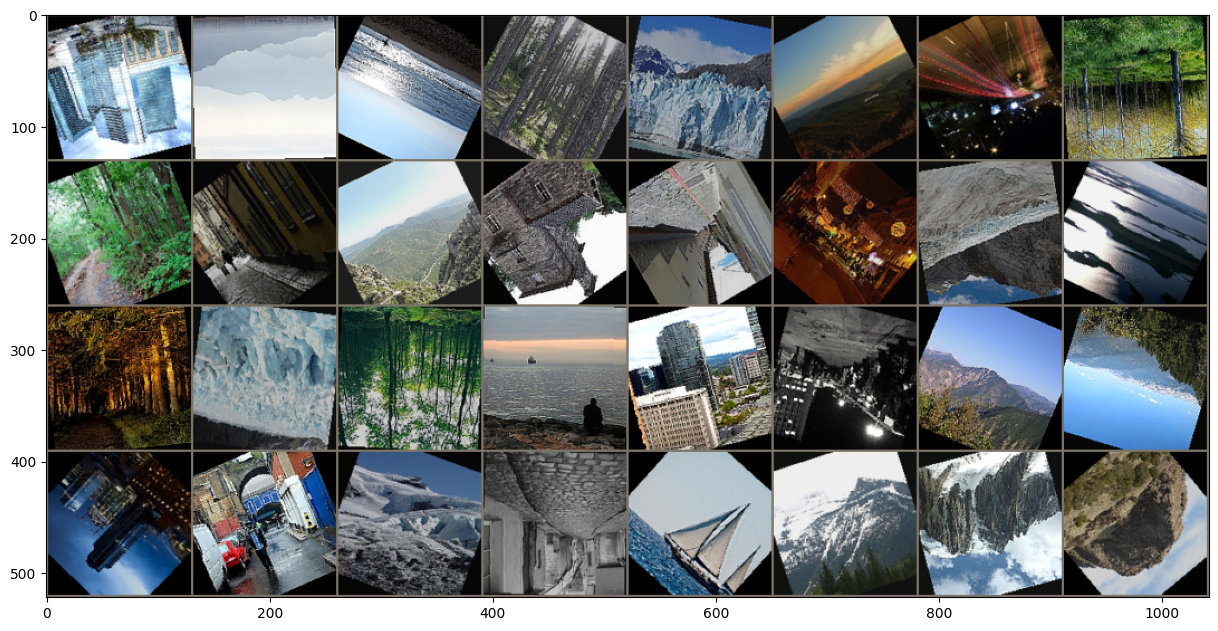

In [13]:
img_grid = make_grid(images,nrow=8)

inv_normalize = transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],std=[1/0.229,1/0.224,1/0.225])
inv_normalized_img = inv_normalize(img_grid)

plt.figure(figsize=(15,15))
plt.imshow(np.transpose(inv_normalized_img,(1,2,0)))
plt.show();

## Defining CNN model architecture

In [14]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1) # 64,64,32
        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1) # 32,32,64
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1) # 16,16,128
        self.bn3 = nn.BatchNorm2d(num_features=128)
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1) # 8,8,256
        self.bn4 = nn.BatchNorm2d(num_features=256)
        self.conv5 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride=1,padding=1) # 4,4,512
        self.bn5 = nn.BatchNorm2d(num_features=512)
        self.fc1 = nn.Linear(in_features=4*4*512,out_features=1024)
        self.bn_fc1 = nn.BatchNorm1d(num_features=1024)
        self.fc2 = nn.Linear(in_features=1024,out_features=512)
        self.bn_fc2 = nn.BatchNorm1d(num_features=512)
        self.fc3 = nn.Linear(in_features=512,out_features=256)
        self.bn_fc3 = nn.BatchNorm1d(num_features=256)
        self.fc4 = nn.Linear(in_features=256,out_features=128)
        self.bn_fc4 = nn.BatchNorm1d(num_features=128)
        self.fc5 = nn.Linear(in_features=128,out_features=64)
        self.bn_fc5 = nn.BatchNorm1d(num_features=64)
        self.fc6 = nn.Linear(in_features=64,out_features=32)
        self.bn_fc6 = nn.BatchNorm1d(num_features=32)
        self.fc7 = nn.Linear(in_features=32,out_features=6)

    def forward(self,X):
        X = F.relu(self.bn1(self.conv1(X)))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = F.relu(self.bn2(self.conv2(X)))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = F.relu(self.bn3(self.conv3(X)))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = F.relu(self.bn4(self.conv4(X)))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = F.relu(self.bn5(self.conv5(X)))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = X.view(-1,4*4*512)
        X = F.relu(self.bn_fc1(self.fc1(X)))
        X = F.dropout(X,p=0.35)
        X = F.relu(self.bn_fc2(self.fc2(X)))
        X = F.dropout(X,p=0.3)
        X = F.relu(self.bn_fc3(self.fc3(X)))
        X = F.dropout(X,p=0.25)
        X = F.relu(self.bn_fc4(self.fc4(X)))
        X = F.dropout(X,p=0.2)
        X = F.relu(self.bn_fc5(self.fc5(X)))
        X = F.dropout(X,p=0.1)
        X = F.relu(self.bn_fc6(self.fc6(X)))
        X = F.dropout(X,p=0.1)
        X = self.fc7(X)
        return F.log_softmax(X,dim=1)

In [15]:
torch.manual_seed(42)
model = CNN().cuda()
model

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=8192, out_features=1024, bias=True)
  (bn_fc1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [16]:
summary(model)

Layer (type:depth-idx)                   Param #
CNN                                      --
├─Conv2d: 1-1                            896
├─BatchNorm2d: 1-2                       64
├─Conv2d: 1-3                            18,496
├─BatchNorm2d: 1-4                       128
├─Conv2d: 1-5                            73,856
├─BatchNorm2d: 1-6                       256
├─Conv2d: 1-7                            295,168
├─BatchNorm2d: 1-8                       512
├─Conv2d: 1-9                            1,180,160
├─BatchNorm2d: 1-10                      1,024
├─Linear: 1-11                           8,389,632
├─BatchNorm1d: 1-12                      2,048
├─Linear: 1-13                           524,800
├─BatchNorm1d: 1-14                      1,024
├─Linear: 1-15                           131,328
├─BatchNorm1d: 1-16                      512
├─Linear: 1-17                           32,896
├─BatchNorm1d: 1-18                      256
├─Linear: 1-19                           8,256
├─BatchNorm1

In [17]:
total_params = 0

for param in model.parameters():
    print(param.numel())
    total_params += param.numel()

print("Total CNN model parameters:", total_params)

864
32
32
32
18432
64
64
64
73728
128
128
128
294912
256
256
256
1179648
512
512
512
8388608
1024
1024
1024
524288
512
512
512
131072
256
256
256
32768
128
128
128
8192
64
64
64
2048
32
32
32
192
6
Total CNN model parameters: 10663782


## Model Training & Validation

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(),lr=1e-5,weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=15,min_lr=1e-8,verbose=True)
early_stopping = EarlyStopping(patience=60,verbose=True)

In [19]:
epochs = 100

train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

start_time = time.time()

for i in range(1,epochs+1):
    train_correct = 0
    val_correct = 0

    model.train()
    
    for _, (X_train, y_train) in enumerate(train_data_loader):
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred,y_train)
        nn.utils.clip_grad_norm_(parameters=model.parameters(),max_norm=1.0) # Gradient Clipping
        loss.backward()
        optimizer.step()
        predicted = torch.max(y_pred,1)[1]
        train_correct += (predicted == y_train).sum().item()

    train_losses.append(loss.item())
    train_accuracies.append(train_correct/len(train_data_loader.dataset))

    model.eval()

    with torch.no_grad():

        for _, (X_val, y_val) in enumerate(validation_data_loader):
            X_val, y_val = X_val.to(device), y_val.to(device)
            y_pred = model(X_val)
            predicted = torch.max(y_pred,1)[1]
            val_correct += (predicted == y_val).sum().item()

    val_loss = criterion(y_pred,y_val)
    validation_losses.append(val_loss.item())
    validation_accuracies.append(val_correct / len(validation_data_loader.dataset))

    print(f"Epoch {i} -> Train Loss: {loss.item()} Train Accuracy: {train_correct/len(train_data_loader.dataset)} Validation Loss: {val_loss.item()} Validation Accuracy: {val_correct / len(validation_data_loader.dataset)}")

    scheduler.step(val_loss)
    early_stopping(val_loss.item(),model)

    if early_stopping.early_stop:
        print("Early Stopping")
        break

print(f"Total time elapsed in CNN model training: {(time.time()-start_time)/60} minutes.")

Epoch 1 -> Train Loss: 1.675173044204712 Train Accuracy: 0.2311392179567115 Validation Loss: 1.7256207466125488 Validation Accuracy: 0.2942643391521197
Validation loss decreased (inf --> 1.725621).  Saving model ...
Epoch 2 -> Train Loss: 1.5446292161941528 Train Accuracy: 0.3251091119622339 Validation Loss: 1.6603151559829712 Validation Accuracy: 0.3694335589597435
Validation loss decreased (1.725621 --> 1.660315).  Saving model ...
Epoch 3 -> Train Loss: 1.6111003160476685 Train Accuracy: 0.38158011935512604 Validation Loss: 1.5591652393341064 Validation Accuracy: 0.41467759173494834
Validation loss decreased (1.660315 --> 1.559165).  Saving model ...
Epoch 4 -> Train Loss: 1.6730456352233887 Train Accuracy: 0.4269172530506814 Validation Loss: 1.4101669788360596 Validation Accuracy: 0.4731029568934806
Validation loss decreased (1.559165 --> 1.410167).  Saving model ...
Epoch 5 -> Train Loss: 1.5411725044250488 Train Accuracy: 0.46788990825688076 Validation Loss: 1.4974805116653442 Va

## Visualizing model performance on train and test sets

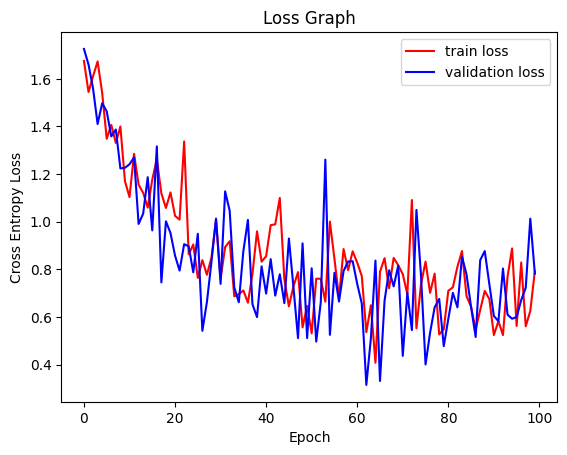

In [20]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(validation_losses,'b',label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

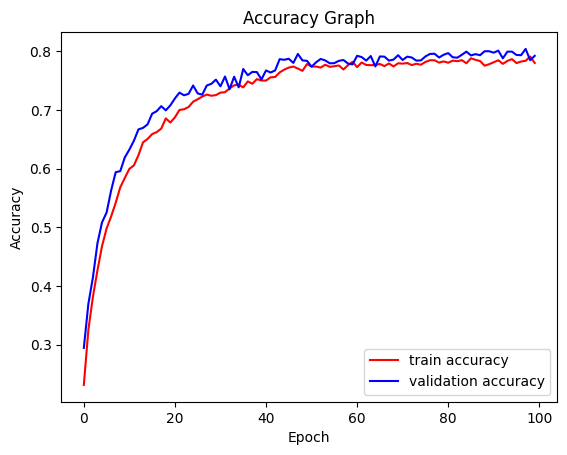

In [21]:
plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(validation_accuracies,'b',label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show()

## Model Evaluation

In [22]:
test_correct = 0
predictions = []
actual_values = []

model.eval() # Set model to evaluation mode

with torch.no_grad():
    for X_test, y_test in test_data_loader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_pred = model(X_test)
        predicted = torch.max(y_pred,1)[1]
        test_correct += (predicted == y_test).sum().item()
        predictions.extend(predicted)
        actual_values.extend(y_test)

print(f"Test accuracy: {round(test_correct / len(test_data_loader.dataset) * 100,2)}%")

Test accuracy: 80.73%


In [23]:
predictions = [x.cpu().item() for x in predictions]
actual_values = [x.cpu().item() for x in actual_values]

Confusion Matrix:
[[336   5   3  12   9  72]
 [  4 458   0   1   0  11]
 [ 20   4 357 102  51  19]
 [ 16   5  39 421  34  10]
 [ 26   4  20  39 413   8]
 [ 49   6   1   4   4 437]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       437
           1       0.95      0.97      0.96       474
           2       0.85      0.65      0.73       553
           3       0.73      0.80      0.76       525
           4       0.81      0.81      0.81       510
           5       0.78      0.87      0.83       501

    accuracy                           0.81      3000
   macro avg       0.81      0.81      0.81      3000
weighted avg       0.81      0.81      0.81      3000



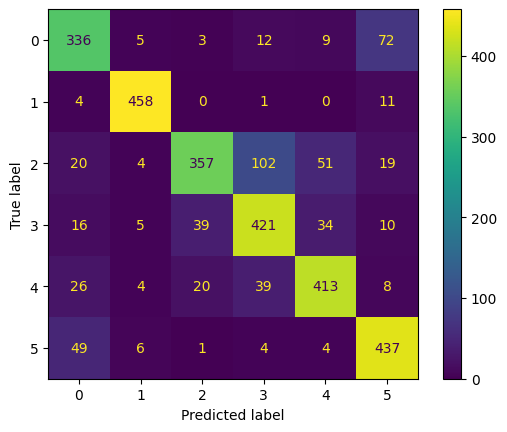

In [24]:
print("Confusion Matrix:")
print(confusion_matrix(actual_values,predictions))
print("Classification Report:")
print(classification_report(actual_values,predictions))
ConfusionMatrixDisplay.from_predictions(actual_values,predictions)
plt.show()

## Saving the model for deployment

In [25]:
torch.save(model.state_dict(),'natural_scenes_image_classifier.pt')

## Model Inference

In [26]:
def generate_prediction(model,image_filepath):
    img = Image.open(image_filepath).convert("RGB")
    transformed_img = test_img_transforms(img).unsqueeze(0).to(device)
    labels = train_dataset.class_to_idx
    labels = {v: k for k, v in labels.items()}
    
    model.eval()
    
    with torch.no_grad():
        probabilities = model(transformed_img)
        pred = torch.max(probabilities,1)[1]

    return labels[pred.item()]

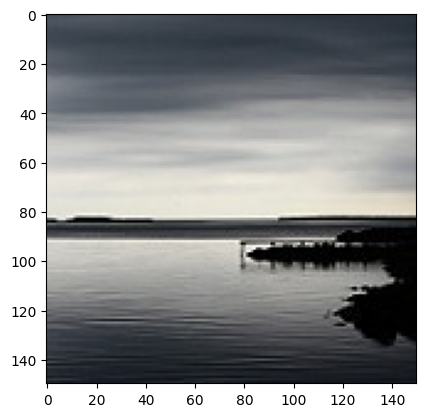

Predicted natural scene: sea


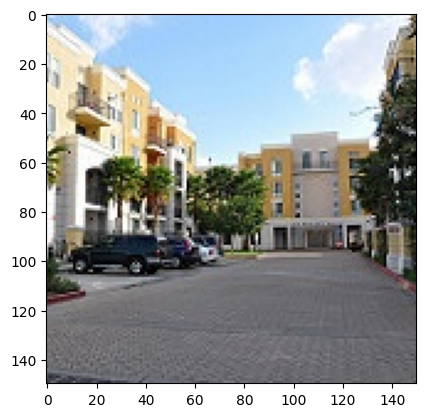

Predicted natural scene: street


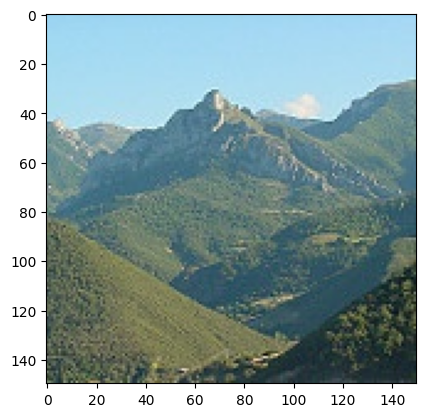

Predicted natural scene: mountain


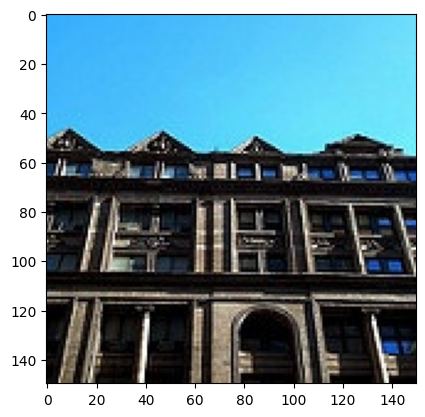

Predicted natural scene: street


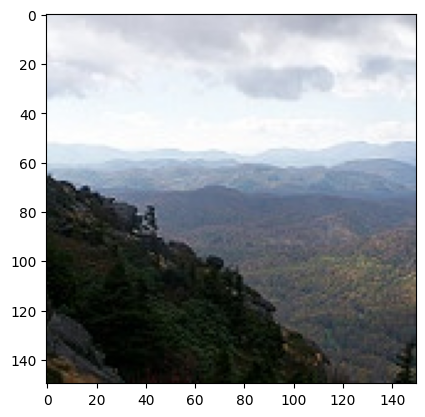

Predicted natural scene: mountain


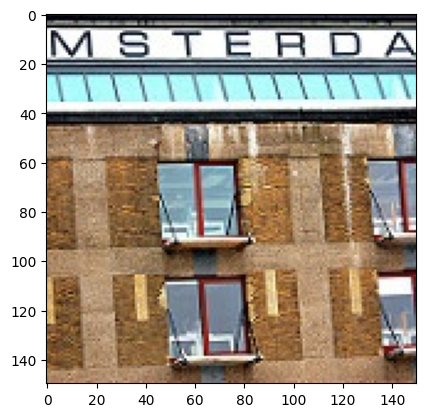

Predicted natural scene: buildings


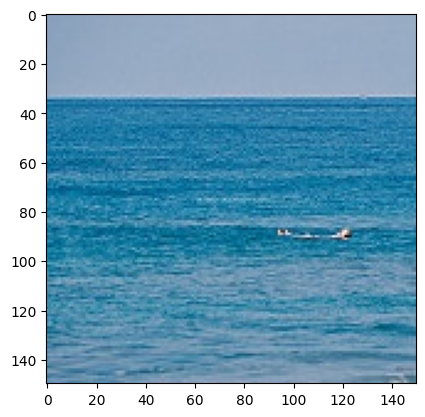

Predicted natural scene: sea


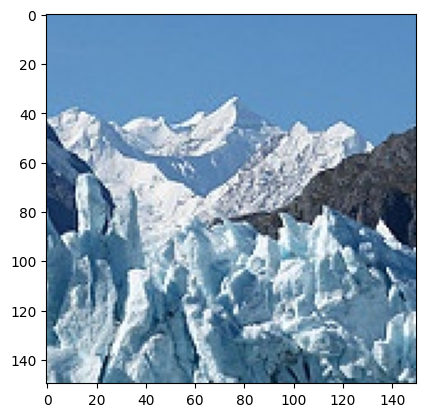

Predicted natural scene: glacier


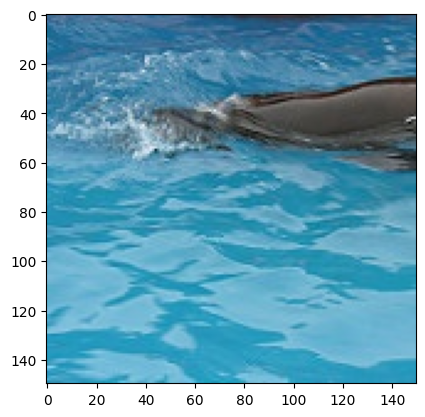

Predicted natural scene: sea


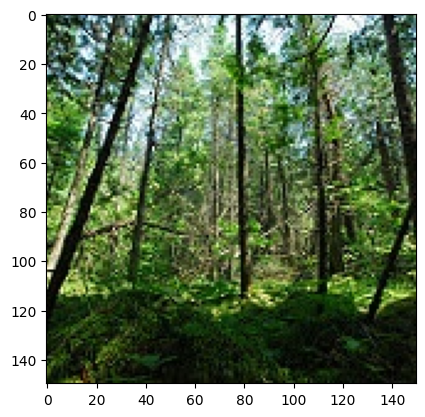

Predicted natural scene: forest


In [27]:
cnt = 0
for img in os.listdir("/kaggle/input/intel-image-classification/seg_pred/seg_pred"):
    img_filepath = os.path.join("/kaggle/input/intel-image-classification/seg_pred/seg_pred/" + img)
    image = Image.open(img_filepath).convert("RGB")
    plt.imshow(image)
    plt.show()
    print("Predicted natural scene:", generate_prediction(model,img_filepath))
    cnt += 1
    if cnt == 10:
        break

## Fine-tuning pretrained ResNet50 model

In [28]:
resnet = models.resnet50(pretrained=True)
resnet

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 197MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [29]:
summary(resnet)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─Bottleneck: 2-1                   --
│    │    └─Conv2d: 3-1                  4,096
│    │    └─BatchNorm2d: 3-2             128
│    │    └─Conv2d: 3-3                  36,864
│    │    └─BatchNorm2d: 3-4             128
│    │    └─Conv2d: 3-5                  16,384
│    │    └─BatchNorm2d: 3-6             512
│    │    └─ReLU: 3-7                    --
│    │    └─Sequential: 3-8              16,896
│    └─Bottleneck: 2-2                   --
│    │    └─Conv2d: 3-9                  16,384
│    │    └─BatchNorm2d: 3-10            128
│    │    └─Conv2d: 3-11                 36,864
│    │    └─BatchNorm2d: 3-12            128
│    │    └─Conv2d: 3-13               

In [30]:
total_params = 0

for param in resnet.parameters():
    param.requires_grad = False
    print(param.numel())
    total_params += param.numel()

print(f"Total ResNet50 model parameters: {total_params}")

9408
64
64
4096
64
64
36864
64
64
16384
256
256
16384
256
256
16384
64
64
36864
64
64
16384
256
256
16384
64
64
36864
64
64
16384
256
256
32768
128
128
147456
128
128
65536
512
512
131072
512
512
65536
128
128
147456
128
128
65536
512
512
65536
128
128
147456
128
128
65536
512
512
65536
128
128
147456
128
128
65536
512
512
131072
256
256
589824
256
256
262144
1024
1024
524288
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
524288
512
512
2359296
512
512
1048576
2048
2048
2097152
2048
2048
1048576
512
512
2359296
512
512
1048576
2048
2048
1048576
512
512
2359296
512
512
1048576
2048
2048
2048000
1000
Total ResNet50 model parameters: 25557032


In [31]:
resnet.fc = nn.Sequential(
    nn.Linear(2048,512),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.3),
    nn.Linear(512,128),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.2),
    nn.Linear(128,6),
    nn.LogSoftmax(dim=1)
) # Modifying the final fully connected layer of ResNet50 model
resnet = resnet.cuda()
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=resnet.parameters(),lr=1e-5,weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer,step_size=20,gamma=0.1)
early_stopping = EarlyStopping(patience=60,verbose=True)

In [33]:
epochs = 100

train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

start_time = time.time()

for i in range(1,epochs+1):
    train_correct = 0
    val_correct = 0

    resnet.train()
    
    for _, (X_train, y_train) in enumerate(train_data_loader):
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        y_pred = resnet(X_train)
        loss = criterion(y_pred,y_train)
        nn.utils.clip_grad_norm_(parameters=resnet.parameters(),max_norm=1.0)
        loss.backward()
        optimizer.step()
        predicted = torch.max(y_pred,1)[1]
        train_correct += (predicted == y_train).sum().item()

    train_losses.append(loss.item())
    train_accuracies.append(train_correct/len(train_data_loader.dataset))

    resnet.eval()

    with torch.no_grad():

        for _, (X_val, y_val) in enumerate(validation_data_loader):
            X_val, y_val = X_val.to(device), y_val.to(device)
            y_pred = resnet(X_val)
            predicted = torch.max(y_pred,1)[1]
            val_correct += (predicted == y_val).sum().item()

    val_loss = criterion(y_pred,y_val)
    validation_losses.append(val_loss.item())
    validation_accuracies.append(val_correct / len(validation_data_loader.dataset))

    print(f"Epoch {i} -> Train Loss: {loss.item()} Train Accuracy: {train_correct/len(train_data_loader.dataset)} Validation Loss: {val_loss.item()} Validation Accuracy: {val_correct / len(validation_data_loader.dataset)}")

    scheduler.step(val_loss)
    early_stopping(val_loss.item(),resnet)

    if early_stopping.early_stop:
        print("Early Stopping")
        break

print(f"Total time elapsed in CNN model training: {(time.time()-start_time)/60} minutes.")

Epoch 1 -> Train Loss: 1.434787631034851 Train Accuracy: 0.4174757281553398 Validation Loss: 1.5019890069961548 Validation Accuracy: 0.683291770573566
Validation loss decreased (inf --> 1.501989).  Saving model ...
Epoch 2 -> Train Loss: 1.1775258779525757 Train Accuracy: 0.6278614055402155 Validation Loss: 1.0760067701339722 Validation Accuracy: 0.755967224795155
Validation loss decreased (1.501989 --> 1.076007).  Saving model ...
Epoch 3 -> Train Loss: 1.0298823118209839 Train Accuracy: 0.6798788634541729 Validation Loss: 0.6766664385795593 Validation Accuracy: 0.7898111863199145
Validation loss decreased (1.076007 --> 0.676666).  Saving model ...
Epoch 4 -> Train Loss: 0.8980329036712646 Train Accuracy: 0.7143493364211276 Validation Loss: 0.7283586263656616 Validation Accuracy: 0.7823298895618097
EarlyStopping counter: 1 out of 60
Epoch 5 -> Train Loss: 0.6826269626617432 Train Accuracy: 0.7335886701701256 Validation Loss: 0.6813440322875977 Validation Accuracy: 0.800498753117207
Ea

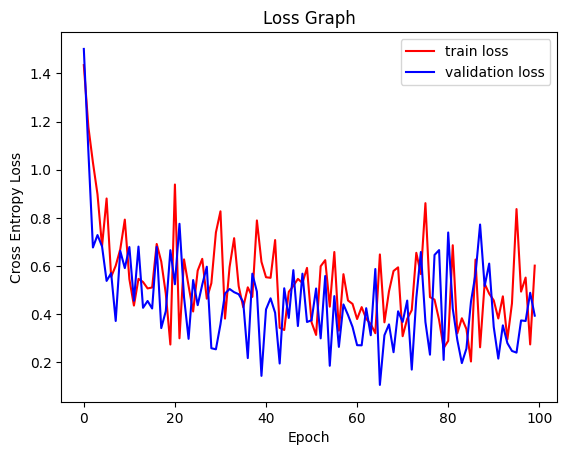

In [34]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(validation_losses,'b',label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

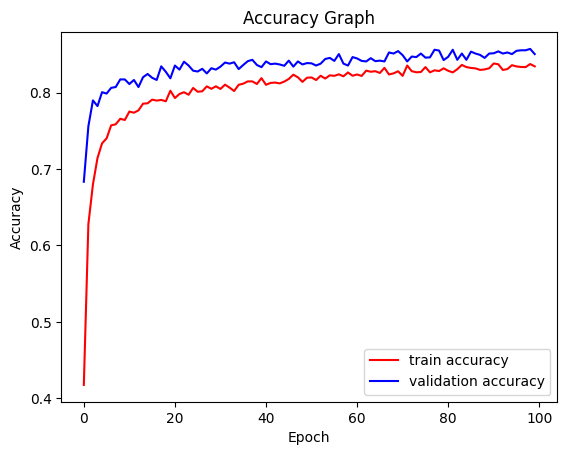

In [35]:
plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(validation_accuracies,'b',label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show()

In [36]:
test_correct = 0
predictions = []
actual_values = []

resnet.eval() # Set model to evaluation mode

with torch.no_grad():
    for X_test, y_test in test_data_loader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_pred = resnet(X_test)
        predicted = torch.max(y_pred,1)[1]
        test_correct += (predicted == y_test).sum().item()
        predictions.extend(predicted)
        actual_values.extend(y_test)

print(f"Test accuracy: {round(test_correct / len(test_data_loader.dataset) * 100,2)}%")

Test accuracy: 86.1%


In [37]:
predictions = [x.cpu().item() for x in predictions]
actual_values = [x.cpu().item() for x in actual_values]

Confusion Matrix:
[[409   1   1   1   5  20]
 [  1 465   2   4   1   1]
 [  2   4 390 103  52   2]
 [  7   1  51 431  32   3]
 [  7   2  16  14 470   1]
 [ 67   1   2   1  12 418]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       437
           1       0.98      0.98      0.98       474
           2       0.84      0.71      0.77       553
           3       0.78      0.82      0.80       525
           4       0.82      0.92      0.87       510
           5       0.94      0.83      0.88       501

    accuracy                           0.86      3000
   macro avg       0.87      0.87      0.86      3000
weighted avg       0.86      0.86      0.86      3000



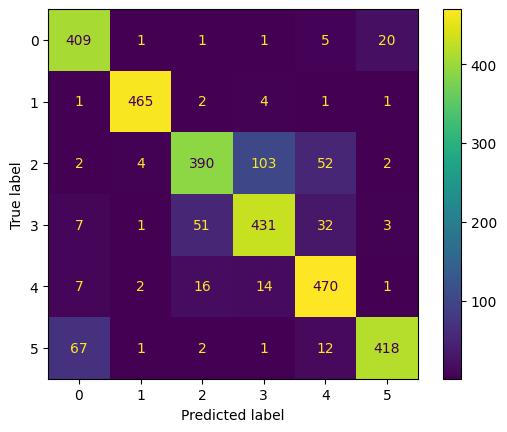

In [38]:
print("Confusion Matrix:")
print(confusion_matrix(actual_values,predictions))
print("Classification Report:")
print(classification_report(actual_values,predictions))
ConfusionMatrixDisplay.from_predictions(actual_values,predictions)
plt.show()

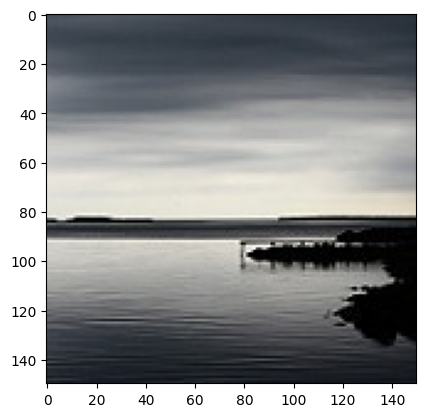

Predicted natural scene: sea


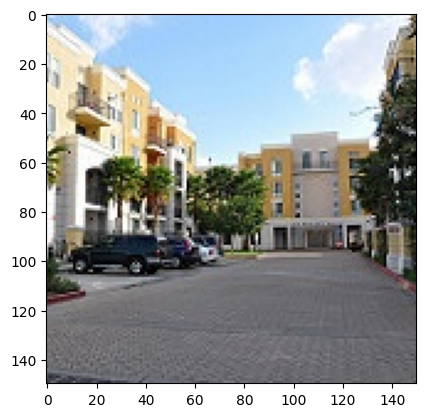

Predicted natural scene: buildings


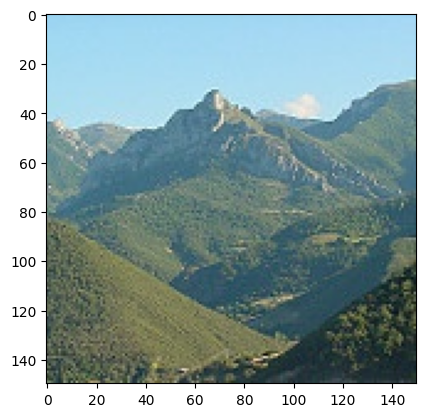

Predicted natural scene: mountain


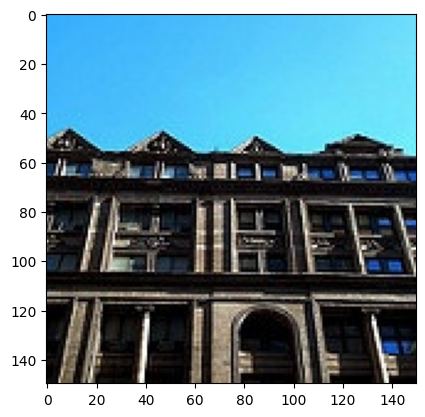

Predicted natural scene: buildings


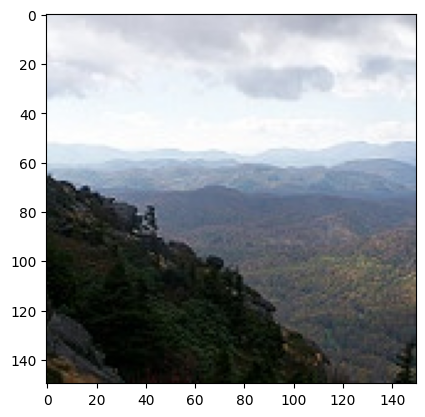

Predicted natural scene: mountain


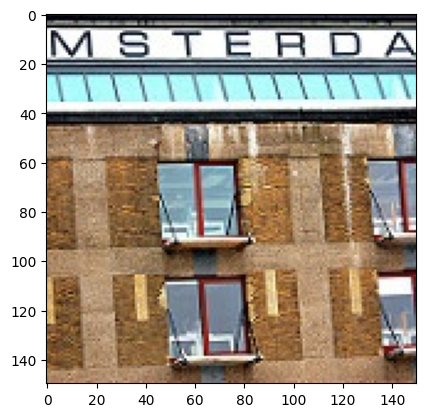

Predicted natural scene: buildings


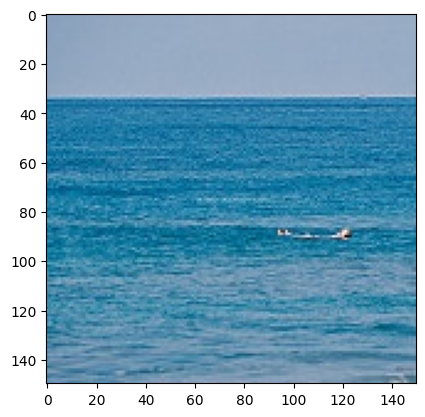

Predicted natural scene: sea


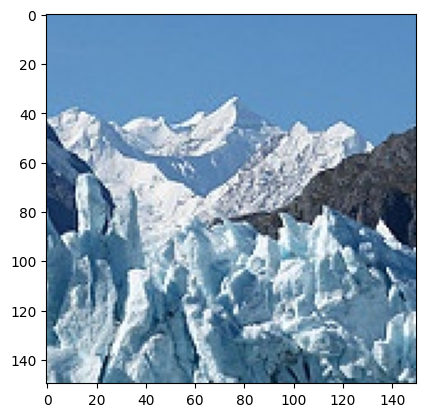

Predicted natural scene: glacier


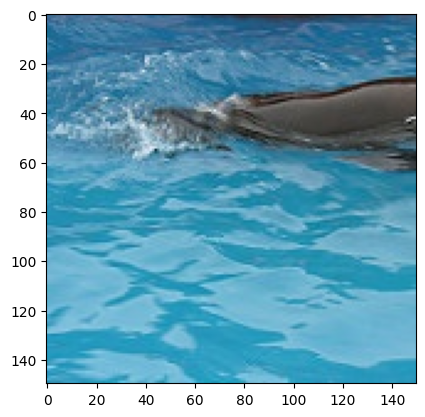

Predicted natural scene: sea


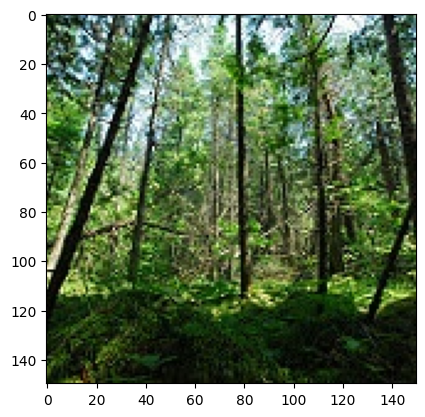

Predicted natural scene: forest


In [39]:
cnt = 0
for img in os.listdir("/kaggle/input/intel-image-classification/seg_pred/seg_pred"):
    img_filepath = os.path.join("/kaggle/input/intel-image-classification/seg_pred/seg_pred/" + img)
    image = Image.open(img_filepath).convert("RGB")
    plt.imshow(image)
    plt.show()
    print("Predicted natural scene:", generate_prediction(resnet,img_filepath))
    cnt += 1
    if cnt == 10:
        break

In [40]:
torch.save(resnet,'natural_scenes_image_resnet_classifier.pt')